In [32]:
import pandas_datareader.data as web
import datetime
start = datetime.datetime(2000,1,1)
end = datetime.datetime(2021,9,1)
df = web.DataReader('GOOGL', 'stooq', start, end)

In [33]:
print(df)
df.dtypes

                Open      High       Low     Close      Volume
Date                                                          
2021-09-01  2900.000  2925.075  2897.670  2904.310   1096805.0
2021-08-31  2902.940  2903.425  2885.620  2893.950   1122438.0
2021-08-30  2888.000  2919.410  2883.260  2891.810   1221710.0
2021-08-27  2833.050  2890.250  2829.940  2880.080   1439010.0
2021-08-26  2835.000  2848.350  2827.140  2828.810   1030466.0
...              ...       ...       ...       ...         ...
2004-08-25    52.480    54.000    51.940    53.000   9197800.0
2004-08-24    55.620    55.800    51.785    52.435  15262600.0
2004-08-23    55.375    56.740    54.525    54.700  18274400.0
2004-08-20    50.505    54.540    50.250    54.155  22857200.0
2004-08-19    50.000    52.030    47.980    50.170  44703800.0

[4290 rows x 5 columns]


Open      float64
High      float64
Low       float64
Close     float64
Volume    float64
dtype: object

In [34]:
# pre_days = 10  #预测10天后的股票价格

#封装函数
def Stock_Price_LSTM_Data_Precesing(df,mem_his_days,pre_days):
    df.dropna(inplace=True)#删掉空值
    df.sort_index(inplace=True)

    df['label']=df['Close'].shift(-pre_days) #不要最后十天的label

    from sklearn.preprocessing import StandardScaler #数据标准化的库
    scaler = StandardScaler() #生成实例对象
    sca_X = scaler.fit_transform(df.iloc[:,:-1]) #标准化所有的行，去除最后一列
    print(sca_X)

    # mem_his_days = 5 #记忆5天的数据
    from collections import deque
    deq = deque(maxlen=mem_his_days) #设置队列先进先出

    X = []
    for i in sca_X:
        deq.append(list(i))
        if len(deq)==mem_his_days:
            X.append(list(deq)) #满了5行数据就存储进X
    #print(len(X))4271 从第5行开始记录，所以少掉4条
    X_lately = X[-pre_days:]#记录最后10条数据
    X = X[:-pre_days] #删除最后十条
#     print(len(X)) #4261

    #记录了label值
    y = df['label'].values[mem_his_days-1:-pre_days]  #构建y的值  从第4条开始到倒数第10条
    # print(len(y))
    # print(y)
    #print(df) #4275*6

    import numpy as np
    X = np.array(X) #转为numpy数组，更直观
    y = np.array(y)
    print(X.shape)
    print(X.shape[1:])
    print(y.shape)
    return X,y,X_lately

In [35]:
X,y,X_lately = Stock_Price_LSTM_Data_Precesing(df,5,10)

[[-1.08801034 -1.08523099 -1.08961219 -1.0866679   4.89712792]
 [-1.08705245 -1.08051426 -1.08526922 -1.07911793  2.09105043]
 [-1.0778149  -1.07638007 -1.07709028 -1.07808538  1.50241458]
 ...
 [ 4.29518661  4.30308185  4.33485023  4.29709095 -0.68791113]
 [ 4.32352522  4.27304322  4.33936538  4.30114538 -0.70066208]
 [ 4.31794854  4.31372739  4.36241946  4.3207734  -0.7039545 ]]
(4275, 5, 5)
(5, 5)
(4275,)


In [37]:
print(len(X))
print(len(y))
print(len(X_lately))

4275
4275
10


In [38]:
pre_days=10
# mem_days = [5,10,15]
# lstm_layers = [1,2,3]
# dense_layers = [1,2,3]
# units = [16,32] #共3*3*3*2次训练
mem_days = [15]
lstm_layers = [2]
dense_layers = [1]
units = [32] #共3*3*3*2次训练
#该回调函数将在每个epoch后保存模型到filepath
from tensorflow.keras.callbacks import ModelCheckpoint
for the_mem_days in mem_days:
    for the_lstm_layers in lstm_layers:
        for the_dense_layers in dense_layers:
            for the_units in units:
                filepath = './models/{val_mape:.2f}_{epoch:02d}_'+f'men_{the_mem_days}_lstm_{the_lstm_layers}_dense_{the_dense_layers}_unit_{the_units}'
                checkpoint = ModelCheckpoint(
                    filepath=filepath,#文件路径
                    save_weights_only=False, #若设置为True,则只保存模型权重,否则将保存整个模型
                    monitor='val_mape', #判断标准
                    mode='min',#越小越好
                    save_best_only=True)

                X,y,X_lately = Stock_Price_LSTM_Data_Precesing(df,the_mem_days,pre_days)
                from sklearn.model_selection import train_test_split #划分数据集
                #shuffle=False不要打乱数据集
                X_train, X_test, y_train, y_test = train_test_split(X,y,shuffle=False,test_size=0.1)
                
                #构建LSTM的神经网络
                import tensorflow as tf
                from tensorflow.keras.models import Sequential #顺序模型
                from tensorflow.keras.layers import LSTM, Dense, Dropout #引入 LSTM层  全连接层 遗忘层
                model = Sequential()

                #10个神经元，输入，激活函数relu,返回值
                #构建第一层
                model.add(LSTM(the_units,input_shape=X.shape[1:],activation='relu',return_sequences=True))
                model.add(Dropout(0.1))#防止过拟合遗忘0.1

                #构建第二层
                for i in range(the_lstm_layers):
                    model.add(LSTM(the_units,activation='relu',return_sequences=True))
                    model.add(Dropout(0.1))#防止过拟合遗忘0.1

                #构建第三层
                model.add(LSTM(the_units,activation='relu'))
                model.add(Dropout(0.1))#防止过拟合遗忘0.1

                for i in range(the_dense_layers):
                #构建全连接层
                    model.add(Dense(the_units,activation='relu'))
                    model.add(Dropout(0.1))#防止过拟合遗忘0.1

                #构建输出层
                model.add(Dense(1))

                #编译
                model.compile(optimizer='adam',#优化器
                             loss='mse',#损失函数   因为是回归的，选择一个损失函数 均方差损失
                             metrics=['mape'])#评价

                #训练  
                #batch_siz一次训练所选取的样本数  
                #epochs 迭代次数\
                #validation_data 校验数据集
                model.fit(X_train,y_train,batch_size=32,epochs=50,validation_data=(X_test,y_test),callbacks=[checkpoint])

                #mape 训练集误差
                # val_mape 校验集误差 平均误差率

[[-1.09952482 -1.09673602 -1.10145759 -1.09836588  4.8925551 ]
 [-1.09854806 -1.09192612 -1.09702755 -1.09066533  2.08816898]
 [-1.08912856 -1.08771028 -1.08868464 -1.08961218  1.49988794]
 ...
 [ 4.12374685  4.10641906  4.08577437  4.15003004 -0.70218429]
 [ 4.13245476  4.10270145  4.11634553  4.08633863 -0.70656906]
 [ 4.08410005  4.05819556  4.08666233  4.0394783  -0.72233421]]
(4255, 15, 5)
(15, 5)
(4255,)


In [39]:
#将最优的模型保存下来
from tensorflow.keras.models import load_model
best_model = load_model('./models/5.47_42_men_15_lstm_2_dense_1_unit_32')

In [40]:
# best_model.summary()#输出最优模型的摘要
# best_model.evaluate(X_test,y_test) #评估模型
# model.evaluate(X_test,y_test) #最后训练出来的的model评估模型
pre = best_model.predict(X_test) #根据模型,输入X测试集生成预测
print(len(pre))

426


<class 'pandas.core.indexes.datetimes.DatetimeIndex'>


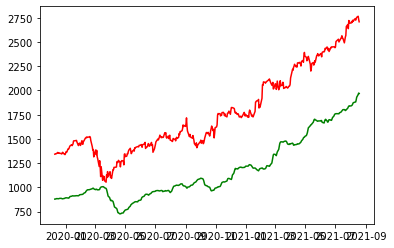

In [42]:
#画图
import matplotlib.pyplot as plt
# print(df_time)

df_time = df.index[-len(y_test):]
print(type(df_time))
plt.plot(df_time,y_test,color='red',label='price') #X轴是日期,y是真实股价
plt.plot(df_time,pre,color='green',label='predict') #预测的值
plt.show()


In [24]:
print(len(y_test))#测试集y的长度，真实数据

NameError: name 'y_test' is not defined